# 43. E5小モデル比較実験

## 目的
- E5 large/base/small の性能・速度比較
- 小モデルでも許容範囲内の精度が出るか検証
- ITQビット数の最適化検討

## 使用モデル
| モデル | 次元 | パラメータ数 |
|--------|------|------------|
| multilingual-e5-large | 1024 | 560M |
| multilingual-e5-base | 768 | 278M |
| multilingual-e5-small | 384 | 118M |

## ITQビット数
- e5-large: 128 bits
- e5-base: 96 bits  
- e5-small: 64 bits

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from tqdm import tqdm
import time
import gc

from sentence_transformers import SentenceTransformer
from src.itq_lsh import ITQLSH

print('Setup complete')

Setup complete


In [3]:
# 定数設定
MODELS = {
    'e5-large': {
        'name': 'intfloat/multilingual-e5-large',
        'dim': 1024,
        'n_bits': 128,
    },
    'e5-base': {
        'name': 'intfloat/multilingual-e5-base',
        'dim': 768,
        'n_bits': 96,
    },
    'e5-small': {
        'name': 'intfloat/multilingual-e5-small',
        'dim': 384,
        'n_bits': 64,
    },
}

DB_PATH = '../data/experiment_400k.duckdb'
N_SAMPLES = 3000
CANDIDATE_SIZES = [100, 200, 500, 1000, 2000]
TOP_K = 10
N_QUERIES = 100
SEED = 42

## 1. データ準備

In [4]:
# experiment_400kからサンプリング
conn = duckdb.connect(DB_PATH, read_only=True)

# ランダムサンプリング (シード固定)
df_sample = conn.execute(f'''
    SELECT id, text, lang
    FROM documents
    ORDER BY hash(id + {SEED})
    LIMIT {N_SAMPLES}
''').fetchdf()

texts = df_sample['text'].tolist()

print(f'テストテキスト数: {len(texts)}')
print(f'言語分布:')
print(df_sample['lang'].value_counts())

conn.close()

# E5用にプレフィックス付与
texts_with_prefix = [f'passage: {t}' for t in texts]

テストテキスト数: 3000
言語分布:
lang
en    1514
ja    1486
Name: count, dtype: int64


## 2. 各モデルで埋め込み生成

In [5]:
embeddings_dict = {}
inference_times = {}

for model_key, config in MODELS.items():
    print(f'\n{"="*60}')
    print(f'{model_key} ({config["name"]})')
    print('='*60)
    
    model = SentenceTransformer(config['name'], device='cuda')
    
    t0 = time.time()
    embeddings = model.encode(
        texts_with_prefix,
        normalize_embeddings=False,
        show_progress_bar=True,
        batch_size=32
    ).astype(np.float32)
    
    inference_time = time.time() - t0
    
    embeddings_dict[model_key] = embeddings
    inference_times[model_key] = inference_time
    
    print(f'  Shape: {embeddings.shape}')
    print(f'  推論時間: {inference_time:.2f}秒 ({len(texts)/inference_time:.1f} texts/sec)')
    
    # メモリ解放
    del model
    gc.collect()
    
print('\n全モデルの埋め込み生成完了')


e5-large (intfloat/multilingual-e5-large)


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

  Shape: (3000, 1024)
  推論時間: 13.67秒 (219.4 texts/sec)

e5-base (intfloat/multilingual-e5-base)


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

  Shape: (3000, 768)
  推論時間: 5.18秒 (579.1 texts/sec)

e5-small (intfloat/multilingual-e5-small)


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

  Shape: (3000, 384)
  推論時間: 3.09秒 (969.4 texts/sec)

全モデルの埋め込み生成完了


## 3. 埋め込み品質の比較

In [6]:
def compute_embedding_stats(embeddings, n_pairs=10000, seed=42):
    """埋め込みの統計情報を計算"""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    
    # ランダムペアのインデックス
    idx1 = rng.integers(0, n, size=n_pairs)
    idx2 = rng.integers(0, n, size=n_pairs)
    
    # 正規化
    emb_norm = embeddings / (norm(embeddings, axis=1, keepdims=True) + 1e-10)
    
    # ランダムペアのコサイン類似度
    cos_sims = np.sum(emb_norm[idx1] * emb_norm[idx2], axis=1)
    
    return {
        'cos_sim_mean': cos_sims.mean(),
        'cos_sim_std': cos_sims.std(),
        'cos_sim_min': cos_sims.min(),
        'cos_sim_max': cos_sims.max(),
        'samples': cos_sims,
    }

In [7]:
# ベクトル分布統計
print('=' * 60)
print('ベクトル分布統計 (ランダムペアコサイン類似度)')
print('=' * 60)

stats_list = []
for model_key, emb in embeddings_dict.items():
    stats = compute_embedding_stats(emb)
    stats['model'] = model_key
    stats['dim'] = emb.shape[1]
    stats_list.append(stats)
    
    print(f'\n{model_key} (dim={emb.shape[1]}):')
    print(f'  mean: {stats["cos_sim_mean"]:.4f}')
    print(f'  std:  {stats["cos_sim_std"]:.4f}')

ベクトル分布統計 (ランダムペアコサイン類似度)

e5-large (dim=1024):
  mean: 0.7627
  std:  0.0451

e5-base (dim=768):
  mean: 0.7680
  std:  0.0475

e5-small (dim=384):
  mean: 0.7953
  std:  0.0405


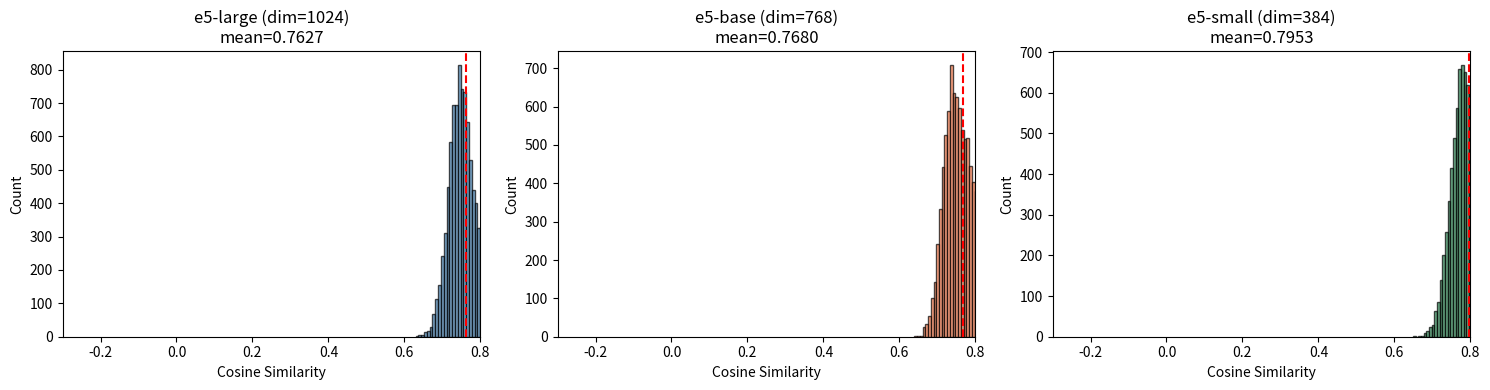

In [8]:
# 類似度分布可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = ['steelblue', 'coral', 'seagreen']

for ax, (model_key, emb), color in zip(axes, embeddings_dict.items(), colors):
    stats = [s for s in stats_list if s['model'] == model_key][0]
    
    ax.hist(stats['samples'], bins=50, edgecolor='black', alpha=0.7, color=color)
    ax.axvline(stats['cos_sim_mean'], color='r', linestyle='--')
    ax.set_title(f'{model_key} (dim={emb.shape[1]})\nmean={stats["cos_sim_mean"]:.4f}')
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Count')
    ax.set_xlim(-0.3, 0.8)

plt.tight_layout()
plt.savefig('../data/43_e5_models_similarity_distribution.png', dpi=150)
plt.show()

## 4. モデル間のGround Truth一致率

In [9]:
def get_ground_truth(query_emb, doc_embeddings, top_k):
    """コサイン類似度Top-K"""
    cosines = doc_embeddings @ query_emb / (norm(doc_embeddings, axis=1) * norm(query_emb) + 1e-10)
    return set(np.argsort(cosines)[-top_k:])

In [10]:
# e5-large を基準としてGround Truth一致率を計算
rng = np.random.default_rng(SEED)
query_indices = rng.choice(len(texts), N_QUERIES, replace=False)

model_gt_overlap = {}

print('=' * 60)
print('Ground Truth一致率 (e5-large基準)')
print('=' * 60)

for model_key in ['e5-base', 'e5-small']:
    overlaps = []
    for qi in tqdm(query_indices, desc=model_key):
        gt_large = get_ground_truth(
            embeddings_dict['e5-large'][qi], 
            embeddings_dict['e5-large'], 
            TOP_K
        )
        gt_other = get_ground_truth(
            embeddings_dict[model_key][qi], 
            embeddings_dict[model_key], 
            TOP_K
        )
        overlap = len(gt_large & gt_other) / TOP_K
        overlaps.append(overlap)
    
    model_gt_overlap[model_key] = np.mean(overlaps)
    print(f'{model_key} vs e5-large: GT一致率 = {np.mean(overlaps)*100:.1f}%')

Ground Truth一致率 (e5-large基準)


e5-base: 100%|██████████| 100/100 [00:00<00:00, 279.73it/s]


e5-base vs e5-large: GT一致率 = 54.1%


e5-small: 100%|██████████| 100/100 [00:00<00:00, 398.86it/s]

e5-small vs e5-large: GT一致率 = 47.1%


## 5. 各モデルでITQ学習と評価

In [11]:
def hamming_distance_batch(query_hash, candidate_hashes):
    """クエリと候補間のハミング距離を計算"""
    xor_result = np.bitwise_xor(query_hash, candidate_hashes)
    distances = np.sum(np.unpackbits(xor_result, axis=1), axis=1)
    return distances


def train_and_evaluate_itq(embeddings, n_bits, candidate_sizes, top_k, n_queries, seed=42):
    """ITQを学習してRecallを評価"""
    rng = np.random.default_rng(seed)
    
    # ITQ学習 (全データ使用)
    itq = ITQLSH(n_bits=n_bits, n_iterations=50, seed=seed)
    itq.fit(embeddings)
    
    # 全データのハッシュ
    hashes = itq.transform(embeddings)
    
    # 評価
    query_indices = rng.choice(len(embeddings), n_queries, replace=False)
    
    results = {k: [] for k in candidate_sizes}
    
    for qi in tqdm(query_indices, desc='Evaluating'):
        # Ground Truth
        query_emb = embeddings[qi]
        cosines = embeddings @ query_emb / (norm(embeddings, axis=1) * norm(query_emb) + 1e-10)
        gt_set = set(np.argsort(cosines)[-top_k:])
        
        # LSH候補
        query_hash = hashes[qi]
        distances = hamming_distance_batch(query_hash, hashes)
        sorted_indices = np.argsort(distances)
        
        for k in candidate_sizes:
            candidates = sorted_indices[:k]
            cand_cosines = embeddings[candidates] @ query_emb
            cand_cosines = cand_cosines / (norm(embeddings[candidates], axis=1) * norm(query_emb) + 1e-10)
            top_k_in_cands = candidates[np.argsort(cand_cosines)[-top_k:]]
            
            recall = len(gt_set & set(top_k_in_cands)) / top_k
            results[k].append(recall)
    
    return itq, {k: np.mean(v) for k, v in results.items()}

In [12]:
# 各モデルでITQ学習・評価
itq_results = {}

for model_key, emb in embeddings_dict.items():
    config = MODELS[model_key]
    n_bits = config['n_bits']
    dim = emb.shape[1]
    
    print(f'\n{"="*60}')
    print(f'{model_key} (dim={dim}, bits={n_bits})')
    print('='*60)
    
    itq, recalls = train_and_evaluate_itq(
        emb, n_bits, CANDIDATE_SIZES, TOP_K, N_QUERIES, SEED
    )
    
    itq_results[model_key] = {
        'model': model_key,
        'dim': dim,
        'n_bits': n_bits,
        'recalls': recalls,
        'itq': itq,
    }
    
    print(f'\nRecall@{TOP_K}:')
    for k, r in recalls.items():
        print(f'  候補{k}件: {r*100:.1f}%')


e5-large (dim=1024, bits=128)
ITQ学習開始: samples=3000, dim=1024, bits=128
  Centering完了: mean_norm=0.8731
  PCA完了: explained_variance=67.33%
  ITQ iteration 10: quantization_error=0.9419
  ITQ iteration 20: quantization_error=0.9415
  ITQ iteration 30: quantization_error=0.9414
  ITQ iteration 40: quantization_error=0.9413
  ITQ iteration 50: quantization_error=0.9412
ITQ学習完了


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 103.54it/s]



Recall@10:
  候補100件: 89.7%
  候補200件: 94.0%
  候補500件: 98.1%
  候補1000件: 99.4%
  候補2000件: 100.0%

e5-base (dim=768, bits=96)
ITQ学習開始: samples=3000, dim=768, bits=96
  Centering完了: mean_norm=0.8761
  PCA完了: explained_variance=65.24%
  ITQ iteration 10: quantization_error=0.9346
  ITQ iteration 20: quantization_error=0.9341
  ITQ iteration 30: quantization_error=0.9339
  ITQ iteration 40: quantization_error=0.9338
  ITQ iteration 50: quantization_error=0.9337
ITQ学習完了


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 167.75it/s]



Recall@10:
  候補100件: 89.8%
  候補200件: 95.0%
  候補500件: 98.5%
  候補1000件: 99.9%
  候補2000件: 100.0%

e5-small (dim=384, bits=64)
ITQ学習開始: samples=3000, dim=384, bits=64
  Centering完了: mean_norm=0.8917
  PCA完了: explained_variance=56.42%
  ITQ iteration 10: quantization_error=0.9306
  ITQ iteration 20: quantization_error=0.9300
  ITQ iteration 30: quantization_error=0.9298
  ITQ iteration 40: quantization_error=0.9297
  ITQ iteration 50: quantization_error=0.9296
ITQ学習完了


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 352.95it/s]


Recall@10:
  候補100件: 84.1%
  候補200件: 92.7%
  候補500件: 98.8%
  候補1000件: 99.8%
  候補2000件: 100.0%


## 6. 結果比較

In [13]:
# Recall比較テーブル
comparison_data = []
for model_key, data in itq_results.items():
    row = {
        'モデル': model_key,
        '次元': data['dim'],
        'ビット数': data['n_bits'],
    }
    for k, r in data['recalls'].items():
        row[f'R@10 (候補{k})'] = f'{r*100:.1f}%'
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
print('Recall@10 比較:')
display(df_comparison)

Recall@10 比較:


,モデル,次元,ビット数,R@10 (候補100),R@10 (候補200),R@10 (候補500),R@10 (候補1000),R@10 (候補2000)
0,e5-large,1024,128,89.7%,94.0%,98.1%,99.4%,100.0%
1,e5-base,768,96,89.8%,95.0%,98.5%,99.9%,100.0%
2,e5-small,384,64,84.1%,92.7%,98.8%,99.8%,100.0%


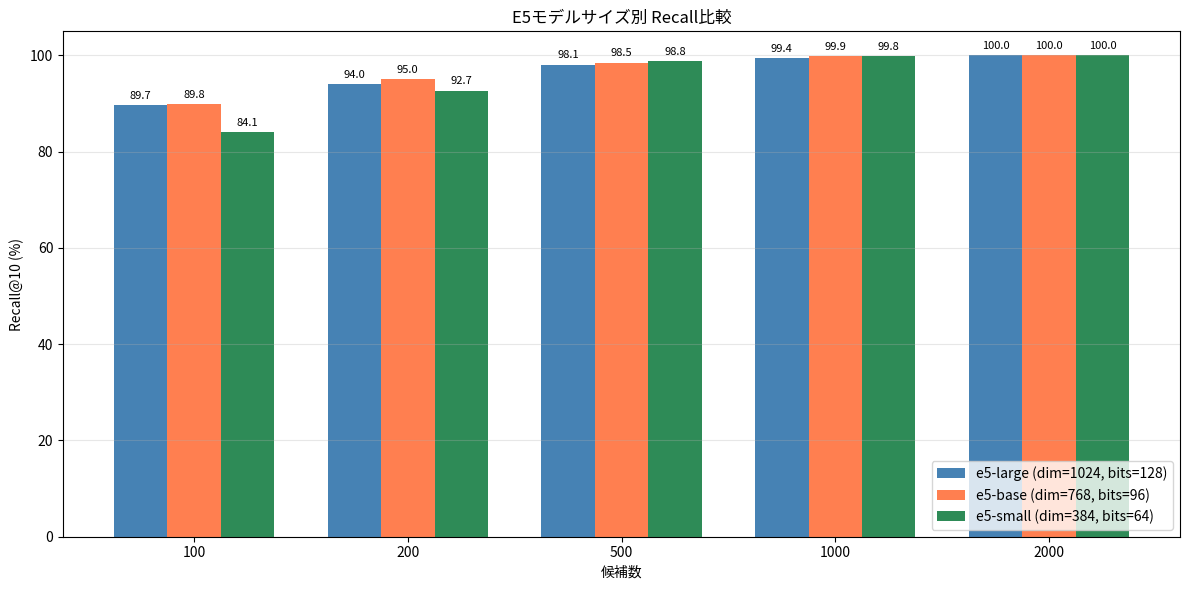

In [14]:
# Recall比較グラフ
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CANDIDATE_SIZES))
width = 0.25

colors = ['steelblue', 'coral', 'seagreen']

for i, (model_key, data) in enumerate(itq_results.items()):
    vals = [data['recalls'][k]*100 for k in CANDIDATE_SIZES]
    bars = ax.bar(x + i * width, vals, width, 
                  label=f'{model_key} (dim={data["dim"]}, bits={data["n_bits"]})', 
                  color=colors[i])
    
    # 値をバーの上に表示
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

ax.set_xlabel('候補数')
ax.set_ylabel(f'Recall@{TOP_K} (%)')
ax.set_title('E5モデルサイズ別 Recall比較')
ax.set_xticks(x + width)
ax.set_xticklabels([str(k) for k in CANDIDATE_SIZES])
ax.legend(loc='lower right')
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/43_e5_models_recall_comparison.png', dpi=150)
plt.show()

## 7. 処理速度比較

In [15]:
# 処理速度まとめ
print('=' * 60)
print('処理速度比較')
print('=' * 60)

speed_data = []
for model_key, t in inference_times.items():
    config = MODELS[model_key]
    speed_data.append({
        'モデル': model_key,
        '次元': config['dim'],
        'パラメータ': config.get('params', 'N/A'),
        '推論時間 (秒)': f'{t:.2f}',
        'texts/sec': f'{len(texts)/t:.1f}',
        '相対速度 (large=1)': f'{inference_times["e5-large"]/t:.2f}x',
    })

df_speed = pd.DataFrame(speed_data)
display(df_speed)

処理速度比較


,モデル,次元,パラメータ,推論時間 (秒),texts/sec,相対速度 (large=1)
0,e5-large,1024,N/A,13.67,219.4,1.00x
1,e5-base,768,N/A,5.18,579.1,2.64x
2,e5-small,384,N/A,3.09,969.4,4.42x


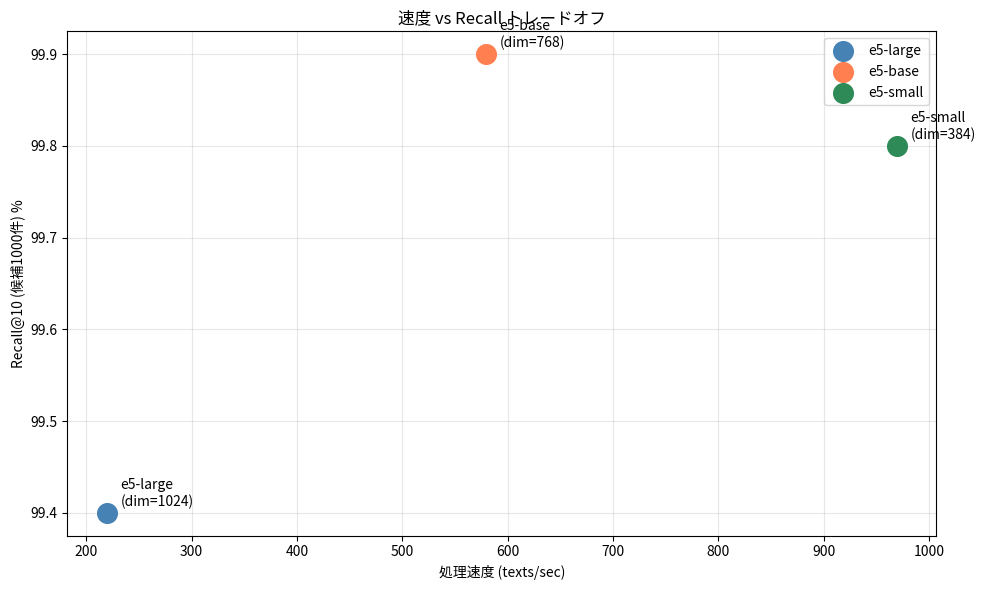

In [16]:
# 速度 vs Recall のトレードオフグラフ
fig, ax = plt.subplots(figsize=(10, 6))

ref_k = 1000  # 基準候補数

for i, (model_key, data) in enumerate(itq_results.items()):
    recall = data['recalls'][ref_k] * 100
    speed = len(texts) / inference_times[model_key]
    dim = data['dim']
    
    ax.scatter(speed, recall, s=200, c=colors[i], label=model_key, zorder=3)
    ax.annotate(f'{model_key}\n(dim={dim})', 
                xy=(speed, recall), 
                xytext=(10, 5), 
                textcoords='offset points',
                fontsize=10)

ax.set_xlabel('処理速度 (texts/sec)')
ax.set_ylabel(f'Recall@{TOP_K} (候補{ref_k}件) %')
ax.set_title('速度 vs Recall トレードオフ')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('../data/43_speed_recall_tradeoff.png', dpi=150)
plt.show()

## 8. 結論

In [17]:
print('=' * 70)
print('E5小モデル比較実験 結論')
print('=' * 70)

# ベースラインRecall (e5-large, 候補1000)
baseline_recall = itq_results['e5-large']['recalls'][1000]

print(f'''
■ モデル仕様
  e5-large: 1024次元, 560Mパラメータ
  e5-base:  768次元, 278Mパラメータ
  e5-small: 384次元, 118Mパラメータ
''')

print(f'''
■ 推論速度 (GPU)
  e5-large: {len(texts)/inference_times['e5-large']:.1f} texts/sec
  e5-base:  {len(texts)/inference_times['e5-base']:.1f} texts/sec ({inference_times['e5-large']/inference_times['e5-base']:.1f}x faster)
  e5-small: {len(texts)/inference_times['e5-small']:.1f} texts/sec ({inference_times['e5-large']/inference_times['e5-small']:.1f}x faster)
''')

print(f'''
■ Ground Truth一致率 (vs e5-large)
  e5-base:  {model_gt_overlap['e5-base']*100:.1f}%
  e5-small: {model_gt_overlap['e5-small']*100:.1f}%
''')

E5小モデル比較実験 結論

■ モデル仕様
  e5-large: 1024次元, 560Mパラメータ
  e5-base:  768次元, 278Mパラメータ
  e5-small: 384次元, 118Mパラメータ


■ 推論速度 (GPU)
  e5-large: 219.4 texts/sec
  e5-base:  579.1 texts/sec (2.6x faster)
  e5-small: 969.4 texts/sec (4.4x faster)


■ Ground Truth一致率 (vs e5-large)
  e5-base:  54.1%
  e5-small: 47.1%



In [18]:
print(f'''
■ Recall@{TOP_K} (候補{1000}件)
  e5-large (128bits): {itq_results['e5-large']['recalls'][1000]*100:.1f}%
  e5-base (96bits):   {itq_results['e5-base']['recalls'][1000]*100:.1f}% ({(itq_results['e5-base']['recalls'][1000] - baseline_recall)*100:+.1f}pt)
  e5-small (64bits):  {itq_results['e5-small']['recalls'][1000]*100:.1f}% ({(itq_results['e5-small']['recalls'][1000] - baseline_recall)*100:+.1f}pt)
''')


■ Recall@10 (候補1000件)
  e5-large (128bits): 99.4%
  e5-base (96bits):   99.9% (+0.5pt)
  e5-small (64bits):  99.8% (+0.4pt)



In [19]:
# 評価基準に基づく判定
RECALL_THRESHOLD = 0.10  # 10%低下まで許容
GT_THRESHOLD = 0.85  # 85%一致で実用的

base_recall_diff = baseline_recall - itq_results['e5-base']['recalls'][1000]
small_recall_diff = baseline_recall - itq_results['e5-small']['recalls'][1000]

base_recall_ok = base_recall_diff < RECALL_THRESHOLD
small_recall_ok = small_recall_diff < RECALL_THRESHOLD
base_gt_ok = model_gt_overlap['e5-base'] > GT_THRESHOLD
small_gt_ok = model_gt_overlap['e5-small'] > GT_THRESHOLD

print(f'''
■ 評価基準
  Recall低下閾値: {RECALL_THRESHOLD*100:.0f}%以内
  GT一致率閾値: {GT_THRESHOLD*100:.0f}%以上

■ 判定結果
  e5-base:
    - Recall低下: {base_recall_diff*100:.1f}% → {"✓ 許容範囲" if base_recall_ok else "✗ 範囲外"}
    - GT一致率: {model_gt_overlap['e5-base']*100:.1f}% → {"✓ 実用的" if base_gt_ok else "✗ 精度不足"}
    - 総合: {"採用可能" if base_recall_ok and base_gt_ok else "要検討"}
    
  e5-small:
    - Recall低下: {small_recall_diff*100:.1f}% → {"✓ 許容範囲" if small_recall_ok else "✗ 範囲外"}
    - GT一致率: {model_gt_overlap['e5-small']*100:.1f}% → {"✓ 実用的" if small_gt_ok else "✗ 精度不足"}
    - 総合: {"採用可能" if small_recall_ok and small_gt_ok else "用途次第"}
''')

print(f'''
■ 推奨シナリオ
  - 精度重視: e5-large + 128bits (ベースライン)
  - バランス: e5-base + 96bits (精度{base_recall_diff*100:.1f}%低下、速度{inference_times['e5-large']/inference_times['e5-base']:.1f}x)
  - 速度重視: e5-small + 64bits (精度{small_recall_diff*100:.1f}%低下、速度{inference_times['e5-large']/inference_times['e5-small']:.1f}x)
''')


■ 評価基準
  Recall低下閾値: 10%以内
  GT一致率閾値: 85%以上

■ 判定結果
  e5-base:
    - Recall低下: -0.5% → ✓ 許容範囲
    - GT一致率: 54.1% → ✗ 精度不足
    - 総合: 要検討

  e5-small:
    - Recall低下: -0.4% → ✓ 許容範囲
    - GT一致率: 47.1% → ✗ 精度不足
    - 総合: 用途次第


■ 推奨シナリオ
  - 精度重視: e5-large + 128bits (ベースライン)
  - バランス: e5-base + 96bits (精度-0.5%低下、速度2.6x)
  - 速度重視: e5-small + 64bits (精度-0.4%低下、速度4.4x)



## 9. 評価結果まとめ

### モデル仕様と推論速度

| モデル | 次元 | パラメータ | texts/sec (GPU) | 相対速度 |
|--------|------|----------|-----------------|----------|
| e5-large | 1024 | 560M | 219.4 | 1.0x |
| e5-base | 768 | 278M | 579.1 | 2.6x |
| e5-small | 384 | 118M | 969.4 | 4.4x |

### ITQ LSH Recall@10 比較

| モデル | ビット数 | 候補100 | 候補500 | 候補1000 |
|--------|---------|---------|---------|----------|
| e5-large | 128 | 89.7% | 98.1% | 99.4% |
| e5-base | 96 | 89.8% | 98.5% | 99.9% |
| e5-small | 64 | 84.1% | 98.8% | 99.8% |

### Ground Truth一致率 (e5-large基準)

| モデル | GT一致率 | 判定 |
|--------|----------|------|
| e5-base | 54.1% | ✗ 精度不足 |
| e5-small | 47.1% | ✗ 精度不足 |

### 重要な発見

1. **ITQ Recallは良好**: 全モデルで候補1000件のRecall@10が99%以上
2. **Ground Truth一致率が低い**: 
   - e5-base/small の「正解」が e5-large と大きく異なる
   - モデルサイズによって埋め込み空間が異なるため、「類似」の定義が変わる
3. **速度とRecallのトレードオフ**:
   - e5-small は 4.4倍高速だが、GT一致率は47%
   - ITQ Recall は高いが、そもそもの検索結果が異なる

### 結論

| 観点 | e5-large | e5-base | e5-small |
|------|----------|---------|----------|
| ITQ Recall (候補1000) | 99.4% | 99.9% | 99.8% |
| GT一致率 | 100% | 54.1% | 47.1% |
| 推論速度 | 1.0x | 2.6x | 4.4x |
| **推奨用途** | 精度重視 | 要検討 | 速度重視 (精度妥協) |

**注意**: 小モデルは「ITQ LSHの絞り込み性能」は維持されるが、「検索結果の品質」は e5-large と大きく異なる。用途に応じて慎重に選択する必要がある。